# Full SimCLR1 Implementation - Pytorch
### Kunal S

#### Step 0- Import Packages

In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
from models.resnet_simclr import ResNetSimCLR
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from loss.nt_xent import NTXentLoss
import os
import shutil
import sys

# Step1 - Data Augmentation

In [5]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


### 1.1 Perform Gaussian Blur

In [6]:
import cv2
import numpy as np

np.random.seed(0)


class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size, min=0.1, max=2.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size

    def __call__(self, sample):
        sample = np.array(sample)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < 0.5:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return sample

### 1.2 Perform Color Distortion & Crop

In [7]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from data_aug.gaussian_blur import GaussianBlur
from torchvision import datasets

np.random.seed(0)






In [8]:
class DataSetWrapper(object):

    def __init__(self, batch_size, num_workers, valid_size, input_shape, s):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.valid_size = valid_size
        self.s = s
        self.input_shape = eval(input_shape)

    def get_data_loaders(self):
        data_augment = self._get_simclr_pipeline_transform()

        train_dataset = datasets.STL10('./data', split='train+unlabeled', download=True,
                                       transform=SimCLRDataTransform(data_augment))

        train_loader, valid_loader = self.get_train_validation_data_loaders(train_dataset)
        return train_loader, valid_loader

    def _get_simclr_pipeline_transform(self):
        # get a set of data augmentation transformations as described in the SimCLR paper.
        color_jitter = transforms.ColorJitter(0.8 * self.s, 0.8 * self.s, 0.8 * self.s, 0.2 * self.s)
        data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=self.input_shape[0]),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomApply([color_jitter], p=0.8),
                                              transforms.RandomGrayscale(p=0.2),
                                              GaussianBlur(kernel_size=int(0.1 * self.input_shape[0])),
                                              transforms.ToTensor()])
        return data_transforms

    def get_train_validation_data_loaders(self, train_dataset):
        # obtain training indices that will be used for validation
        num_train = len(train_dataset)
        indices = list(range(num_train))
        np.random.shuffle(indices)

        split = int(np.floor(self.valid_size * num_train))
        train_idx, valid_idx = indices[split:], indices[:split]

        # define samplers for obtaining training and validation batches
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, sampler=train_sampler,
                                  num_workers=self.num_workers, drop_last=True, shuffle=False)

        valid_loader = DataLoader(train_dataset, batch_size=self.batch_size, sampler=valid_sampler,
                                  num_workers=self.num_workers, drop_last=True)
        return train_loader, valid_loader

In [9]:

class SimCLRDataTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        xi = self.transform(sample)
        xj = self.transform(sample)
        return xi, xj

# Step 2 Baseline Encoder

## 2.1 Resnet call for transfer learning

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models




In [11]:
class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False),
                            "resnet50": models.resnet50(pretrained=False)}

        resnet = self._get_basemodel(base_model)
        num_ftrs = resnet.fc.in_features

        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # header projection MLP - for SimCLR 
        self.l1 = nn.Linear(num_ftrs, num_ftrs)
        self.l2 = nn.Linear(num_ftrs, out_dim)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
            print("Feature extractor:", model_name)
            return model
        except:
            raise ("Invalid model name. Check the config file and pass one of: resnet18 or resnet50")

    def forward(self, x):
        h = self.features(x)
        h = h.squeeze()

        x = self.l1(h)
        x = F.relu(x)
        x = self.l2(x)
        return h, x

## 2.2 Full encoder to train from scratch

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


In [13]:
class Encoder(nn.Module):
    def __init__(self, out_dim=64):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # header projection MLP/ Single layer MLP
        self.l1 = nn.Linear(64, 64)
        self.l2 = nn.Linear(64, out_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)

        h = torch.mean(x, dim=[2, 3])

        x = self.l1(h)
        x = F.relu(x)
        x = self.l2(x)

        return h, x

# 2.3 Loss Module

In [14]:
import torch
import numpy as np


class NTXentLoss(torch.nn.Module):

    def __init__(self, device, batch_size, temperature, use_cosine_similarity):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(use_cosine_similarity)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self.device)

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        # x shape: (N, 1, C)
        # y shape: (1, C, 2N)
        # v shape: (N, 2N)
        return v

    def _cosine_simililarity(self, x, y):
        # x shape: (N, 1, C)
        # y shape: (1, 2N, C)
        # v shape: (N, 2N)
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)

        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)

        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature

        labels = torch.zeros(2 * self.batch_size).to(self.device).long()
        loss = self.criterion(logits, labels)

        return loss / (2 * self.batch_size)

# Step 3- Run SimCLR Pipeline

In [15]:
import torch
from models.resnet_simclr import ResNetSimCLR
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from loss.nt_xent import NTXentLoss
import os
import shutil
import sys



### apex support code

In [16]:
apex_support = False
try:
    sys.path.append('./apex')
    from apex import amp

    apex_support = True
except:
    print("Please install apex for mixed precision training from: https://github.com/NVIDIA/apex")
    apex_support = False

import numpy as np

torch.manual_seed(0)




Please install apex for mixed precision training from: https://github.com/NVIDIA/apex


## 3.1 Main  Pipeline  for SimCLR

In [17]:
#main  pipeline execution 

def _save_config_file(model_checkpoints_folder):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        shutil.copy('./config.yaml', os.path.join(model_checkpoints_folder, 'config.yaml'))


class SimCLR(object):

    def __init__(self, dataset, config):
        self.config = config
        self.device = self._get_device()
        self.writer = SummaryWriter()
        self.dataset = dataset
        self.nt_xent_criterion = NTXentLoss(self.device, config['batch_size'], **config['loss'])

    def _get_device(self):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("Running on:", device)
        return device

    def _step(self, model, xis, xjs, n_iter):

        # get the representations and the projections
        ris, zis = model(xis)  # [N,C]

        # get the representations and the projections
        rjs, zjs = model(xjs)  # [N,C]

        # normalize projection feature vectors
        zis = F.normalize(zis, dim=1)
        zjs = F.normalize(zjs, dim=1)

        loss = self.nt_xent_criterion(zis, zjs)
        return loss
    
#using adam and not LARS

    def train(self):

        train_loader, valid_loader = self.dataset.get_data_loaders()

        model = ResNetSimCLR(**self.config["model"]).to(self.device)
        model = self._load_pre_trained_weights(model)
        

        optimizer = torch.optim.Adam(model.parameters(), 3e-4, weight_decay=eval(self.config['weight_decay']))

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                               last_epoch=-1)

        if apex_support and self.config['fp16_precision']:
            model, optimizer = amp.initialize(model, optimizer,
                                              opt_level='O2',
                                              keep_batchnorm_fp32=True)

        model_checkpoints_folder = os.path.join(self.writer.log_dir, 'checkpoints')

        # save config file
        _save_config_file(model_checkpoints_folder)

        n_iter = 0
        valid_n_iter = 0
        best_valid_loss = np.inf

        for epoch_counter in range(self.config['epochs']):
            for (xis, xjs), _ in train_loader:
                optimizer.zero_grad()

                xis = xis.to(self.device)
                xjs = xjs.to(self.device)

                loss = self._step(model, xis, xjs, n_iter)

                if n_iter % self.config['log_every_n_steps'] == 0:
                    self.writer.add_scalar('train_loss', loss, global_step=n_iter)

                if apex_support and self.config['fp16_precision']:
                    with amp.scale_loss(loss, optimizer) as scaled_loss:
                        scaled_loss.backward()
                else:
                    loss.backward()

                optimizer.step()
                n_iter += 1

            # validate the model if requested
            if epoch_counter % self.config['eval_every_n_epochs'] == 0:
                valid_loss = self._validate(model, valid_loader)
                if valid_loss < best_valid_loss:
                    # save the model weights
                    best_valid_loss = valid_loss
                    torch.save(model.state_dict(), os.path.join(model_checkpoints_folder, 'model.pth'))

                self.writer.add_scalar('validation_loss', valid_loss, global_step=valid_n_iter)
                valid_n_iter += 1

            # warmup for the first 10 epochs
            if epoch_counter >= 10:
                scheduler.step()
            self.writer.add_scalar('cosine_lr_decay', scheduler.get_lr()[0], global_step=n_iter)

    def _load_pre_trained_weights(self, model):
        try:
            checkpoints_folder = os.path.join('./runs', self.config['fine_tune_from'], 'checkpoints')
            state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'))
            model.load_state_dict(state_dict)
            print("Loaded pre-trained model with success.")
        except FileNotFoundError:
            print("Pre-trained weights not found. Training from scratch.")

        return model

    def _validate(self, model, valid_loader):

        # validation steps
        with torch.no_grad():
            model.eval()

            valid_loss = 0.0
            counter = 0
            for (xis, xjs), _ in valid_loader:
                xis = xis.to(self.device)
                xjs = xjs.to(self.device)

                loss = self._step(model, xis, xjs, counter)
                valid_loss += loss.item()
                counter += 1
            valid_loss /= counter
        model.train()
        return valid_loss

## 3.2 Run module

In [18]:
# run.py module 
from simclr import SimCLR
import yaml
from data_aug.dataset_wrapper import DataSetWrapper


def main():
    config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
    dataset = DataSetWrapper(config['batch_size'], **config['dataset'])

    simclr = SimCLR(dataset, config)
    simclr.train()


if __name__ == "__main__":
    main()


Please install apex for mixed precision training from: https://github.com/NVIDIA/apex
Running on: cpu
Files already downloaded and verified
Feature extractor: resnet18
Pre-trained weights not found. Training from scratch.


KeyboardInterrupt: 

In [13]:
# run.py
from simclr import SimCLR
import yaml
from data_aug.dataset_wrapper import DataSetWrapper


def main():
    config = yaml.load(open("config2.yaml", "r"), Loader=yaml.FullLoader)
    dataset = DataSetWrapper(config['batch_size'], **config['dataset'])

    simclr = SimCLR(dataset, config)
    simclr.train()


if __name__ == "__main__":
    main()


Running on: cpu
Files already downloaded and verified
Feature extractor: resnet18
Pre-trained weights not found. Training from scratch.


KeyboardInterrupt: 

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

# Step4 - Evaluation

## 4.1 Linear Eval

In [2]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [9]:
folder_name = 'resnet-18_80-epochs'

!gdown https://drive.google.com/uc?id=1c4eVon0sUd-ChVhH6XMpF6nCngNJsAPk # ResNet 18 --> 40 epochs trained
!gdown https://drive.google.com/uc?id=1L0yoeY9i2mzDcj69P4slTWb-cfr3PyoT # ResNet 18 --> 80 epochs trained
!unzip resnet-18_80-epochs


/bin/sh: gdown: command not found
/bin/sh: gdown: command not found
Archive:  resnet-18_80-epochs.zip
   creating: resnet-18_80-epochs/
   creating: resnet-18_80-epochs/checkpoints/
  inflating: resnet-18_80-epochs/checkpoints/config.yaml  
  inflating: resnet-18_80-epochs/checkpoints/model.pth  
  inflating: resnet-18_80-epochs/checkpoints/resnet_simclr.py  
  inflating: resnet-18_80-epochs/events.out.tfevents.1584175972.thallessilva.7272.0  


NameError: name 'ls' is not defined

In [10]:
!ls

Full Resnet.ipynb           env.yml
Full SimCLR1 Pytorch.ipynb  feature_eval
LICENSE.txt                 img
README.md                   loss
ResNet18-Weights-master     models
ResNet18-Weights-master.zip pretrained model
STL10 Images shape.ipynb    requirements.txt
Tensorflow_Notebook.ipynb   resnet-18_80-epochs
Untitled.ipynb              resnet-18_80-epochs.zip
__pycache__                 resnet-18_80-epochs_2
cifar & stl data            run.py
config.yaml                 runs
config2.yaml                simclr.py
data                        stl10_binary
data_aug


In [15]:
# download and extract stl10
!wget http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
!tar -zxvf stl10_binary.tar.gz
!ls

/bin/sh: wget: command not found
tar: Error opening archive: Failed to open 'stl10_binary.tar.gz'
Full Resnet.ipynb           env.yml
Full SimCLR1 Pytorch.ipynb  feature_eval
LICENSE.txt                 img
README.md                   loss
ResNet18-Weights-master     models
ResNet18-Weights-master.zip pretrained model
STL10 Images shape.ipynb    requirements.txt
Tensorflow_Notebook.ipynb   resnet-18_80-epochs
Untitled.ipynb              resnet-18_80-epochs.zip
__pycache__                 resnet-18_80-epochs_2
cifar & stl data            run.py
config.yaml                 runs
config2.yaml                simclr.py
data                        stl10_binary
data_aug


In [16]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import importlib.util

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cpu


In [19]:
#change or correct config file here as it loads from default
checkpoints_folder = os.path.join(folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 512,
 'epochs': 40,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'resnet-18_80-epochs',
 'log_every_n_steps': 50,
 'model': {'out_dim': 256, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(96,96,3)',
  'num_workers': 0,
  'valid_size': 0.05},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [20]:
checkpoints_folder

'resnet-18_80-epochs/checkpoints'

In [21]:
def _load_stl10(prefix="train"):
    X_train = np.fromfile('./stl10_binary/' + prefix + '_X.bin', dtype=np.uint8)
    y_train = np.fromfile('./stl10_binary/' + prefix + '_y.bin', dtype=np.uint8)

    X_train = np.reshape(X_train, (-1, 3, 96, 96)) # CWH
    X_train = np.transpose(X_train, (0, 1, 3, 2)) # CHW

    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train - 1

In [22]:
# load STL-10 train data
X_train, y_train = _load_stl10("train")

train images
(5000, 3, 96, 96)
(5000,)


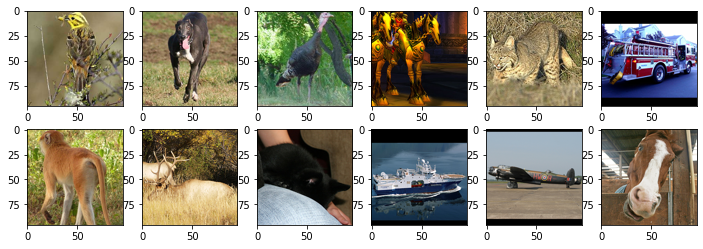

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
  ax.imshow(X_train[i].transpose(1,2,0))
plt.show()

In [24]:
# load STL-10 test data
X_test, y_test = _load_stl10("test")

test images
(8000, 3, 96, 96)
(8000,)


### Testing using PCA

In [25]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train.reshape((X_train.shape[0],-1)))

pca = PCA(n_components=config['model']['out_dim'])

X_train_pca = pca.fit_transform(scaler.transform(X_train.reshape(X_train.shape[0], -1)))
X_test_pca = pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1)))

print("PCA features")
print(X_train_pca.shape)
print(X_test_pca.shape)

PCA features
(5000, 256)
(8000, 256)


In [26]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression(random_state=0, max_iter=1200, solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    
    print("-------------------------------")
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))

In [27]:
linear_model_eval(X_train_pca, y_train, X_test_pca, y_test)

## clean up resources
del X_train_pca
del X_test_pca

Logistic Regression feature eval
Train score: 0.5016
Test score: 0.350875
-------------------------------
KNN feature eval
Train score: 0.4028
Test score: 0.2995


### Test using Logit 

In [28]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, 'resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [29]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [30]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [31]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(5000, 512)


In [32]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

Test features
(8000, 512)


In [33]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_feature)

linear_model_eval(scaler.transform(X_train_feature), y_train, scaler.transform(X_test_feature), y_test)

del X_train_feature
del X_test_feature

Logistic Regression feature eval
Train score: 0.9504
Test score: 0.72925
-------------------------------
KNN feature eval
Train score: 0.7628
Test score: 0.698375


## 4.2 Using Logistic Regression
using resnet 50

In [34]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import importlib.util

In [36]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [37]:
def get_file_id_by_model(folder_name):
  file_id = {'resnet-18_40-epochs': '1c4eVon0sUd-ChVhH6XMpF6nCngNJsAPk',
             'resnet-18_80-epochs': '1L0yoeY9i2mzDcj69P4slTWb-cfr3PyoT',
             'resnet-50_40-epochs': '1TZqBNTFCsO-mxAiR-zJeyupY-J2gA27Q',
             'resnet-50_80-epochs': '1is1wkBRccHdhSKQnPUTQoaFkVNSaCb35',
             'resnet-18_100-epochs':'1aZ12TITXnajZ6QWmS_SDm8Sp8gXNbeCQ'}
  return file_id.get(folder_name, "Model not found.")

In [38]:
folder_name = 'resnet-50_40-epochs'
file_id = get_file_id_by_model(folder_name)
print(folder_name, file_id)

resnet-50_40-epochs 1TZqBNTFCsO-mxAiR-zJeyupY-J2gA27Q


In [39]:
# download and extract model files
os.system('gdown https://drive.google.com/uc?id={}'.format(file_id))
os.system('unzip {}'.format(folder_name))
!ls

Full Resnet.ipynb           env.yml
Full SimCLR1 Pytorch.ipynb  feature_eval
LICENSE.txt                 img
README.md                   loss
ResNet18-Weights-master     models
ResNet18-Weights-master.zip pretrained model
STL10 Images shape.ipynb    requirements.txt
Tensorflow_Notebook.ipynb   resnet-18_80-epochs
Untitled.ipynb              resnet-18_80-epochs.zip
__pycache__                 resnet-18_80-epochs_2
cifar & stl data            run.py
config.yaml                 runs
config2.yaml                simclr.py
data                        stl10_binary
data_aug


In [40]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cpu


In [44]:
#update the yaml file
checkpoints_folder = os.path.join(folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


{'batch_size': 256,
 'epochs': 40,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'resnet-50_40-epochs',
 'log_every_n_steps': 50,
 'model': {'out_dim': 128, 'base_model': 'resnet50'},
 'dataset': {'s': 1,
  'input_shape': '(96,96,3)',
  'num_workers': 0,
  'valid_size': 0.05},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [45]:
def get_stl10_data_loaders(download, shuffle=False, batch_size=128):
  train_dataset = datasets.STL10('./data', split='train', download=download,
                                  transform=transforms.ToTensor())

  train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)
  
  test_dataset = datasets.STL10('./data', split='test', download=download,
                                  transform=transforms.ToTensor())

  test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)
  return train_loader, test_loader

In [46]:
def _load_resnet_model(checkpoints_folder):
  # Load the neural net module
  spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, 'resnet_simclr.py'))
  resnet_module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(resnet_module)

  model = resnet_module.ResNetSimCLR(**config['model'])
  model.eval()

  state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
  model.load_state_dict(state_dict)
  model = model.to(device)
  return model

In [47]:
class ResNetFeatureExtractor(object):
  def __init__(self, checkpoints_folder):
    self.checkpoints_folder = checkpoints_folder
    self.model = _load_resnet_model(checkpoints_folder)

  def _inference(self, loader):
    feature_vector = []
    labels_vector = []
    for batch_x, batch_y in loader:

      batch_x = batch_x.to(device)
      labels_vector.extend(batch_y)

      features, _ = self.model(batch_x)
      feature_vector.extend(features.cpu().detach().numpy())

    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)

    print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector

  def get_resnet_features(self):
    train_loader, test_loader = get_stl10_data_loaders(download=True)
    X_train_feature, y_train = self._inference(train_loader)
    X_test_feature, y_test = self._inference(test_loader)

    return X_train_feature, y_train, X_test_feature, y_test

In [48]:
resnet_feature_extractor = ResNetFeatureExtractor(checkpoints_folder)

Feature extractor: resnet50


In [49]:
X_train_feature, y_train, X_test_feature, y_test = resnet_feature_extractor.get_resnet_features()

Files already downloaded and verified
Files already downloaded and verified
Features shape (5000, 2048)
Features shape (8000, 2048)


In [50]:
import torch.nn as nn

class LogisticRegression(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogisticRegression, self).__init__()
        self.model = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.model(x)

In [51]:
class LogiticRegressionEvaluator(object):
  def __init__(self, n_features, n_classes):
    self.log_regression = LogisticRegression(n_features, n_classes).to(device)
    self.scaler = preprocessing.StandardScaler()

  def _normalize_dataset(self, X_train, X_test):
    print("Standard Scaling Normalizer")
    self.scaler.fit(X_train)
    X_train = self.scaler.transform(X_train)
    X_test = self.scaler.transform(X_test)
    return X_train, X_test

  @staticmethod
  def _sample_weight_decay():
    # We selected the l2 regularization parameter from a range of 45 logarithmically spaced values between 10−6 and 105
    weight_decay = np.logspace(-6, 5, num=45, base=10.0)
    weight_decay = np.random.choice(weight_decay)
    print("Sampled weight decay:", weight_decay)
    return weight_decay

  def eval(self, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
      self.log_regression.eval()
      for batch_x, batch_y in test_loader:
          batch_x, batch_y = batch_x.to(device), batch_y.to(device)
          logits = self.log_regression(batch_x)

          predicted = torch.argmax(logits, dim=1)
          total += batch_y.size(0)
          correct += (predicted == batch_y).sum().item()

      final_acc = 100 * correct / total
      self.log_regression.train()
      return final_acc


  def create_data_loaders_from_arrays(self, X_train, y_train, X_test, y_test):
    X_train, X_test = self._normalize_dataset(X_train, X_test)

    train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).type(torch.long))
    train_loader = torch.utils.data.DataLoader(train, batch_size=396, shuffle=False)

    test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).type(torch.long))
    test_loader = torch.utils.data.DataLoader(test, batch_size=512, shuffle=False)
    return train_loader, test_loader

  def train(self, X_train, y_train, X_test, y_test):
    
    train_loader, test_loader = self.create_data_loaders_from_arrays(X_train, y_train, X_test, y_test)

    weight_decay = self._sample_weight_decay()

    optimizer = torch.optim.Adam(self.log_regression.parameters(), 3e-4, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    best_accuracy = 0

    for e in range(200):
      
      for batch_x, batch_y in train_loader:

        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()

        logits = self.log_regression(batch_x)

        loss = criterion(logits, batch_y)

        loss.backward()
        optimizer.step()

      epoch_acc = self.eval(test_loader)
      
      if epoch_acc > best_accuracy:
        #print("Saving new model with accuracy {}".format(epoch_acc))
        best_accuracy = epoch_acc
        torch.save(self.log_regression.state_dict(), 'log_regression.pth')

    print("--------------")
    print("Done training")
    print("Best accuracy:", best_accuracy)

In [52]:
log_regressor_evaluator = LogiticRegressionEvaluator(n_features=X_train_feature.shape[1], n_classes=10)

log_regressor_evaluator.train(X_train_feature, y_train, X_test_feature, y_test)

Standard Scaling Normalizer
Sampled weight decay: 5.623413251903491e-06
--------------
Done training
Best accuracy: 73.5375
